In [1]:
from os import chdir
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import xgboost as xgb
import numpy as np
import seaborn as sns

In [2]:
train = pd.read_csv('/content/drive/My Drive/drug review datasets/drugsComTest_raw.csv')
train_drugs = train.loc[:, 'drugName']
train = train.loc[:, ['review', 'rating', 'usefulCount']]
train = train.iloc[[x[0] or x[1] for x in list(zip((train['rating'] <= 4), (train['rating'] >= 7)))], :]

In [3]:
train.shape

(48937, 3)

In [4]:
train.head()

,review,rating,usefulCount
0,"""I&#039;ve tried a few antidepressants over th...",10,22
1,"""My son has Crohn&#039;s disease and has done ...",8,17
2,"""Quick reduction of symptoms""",9,3
3,"""Contrave combines drugs that were used for al...",9,35
4,"""I have been on this birth control for one cyc...",9,4


In [5]:
## test set
test = pd.read_csv('/content/drive/My Drive/drug review datasets/drugsComTrain_raw.csv')
test = test.loc[:, ['review', 'rating', 'usefulCount']]
test = test.iloc[[x[0] or x[1] for x in list(zip((test['rating'] <= 4), (test['rating'] >= 7)))], :]

In [6]:
# Pre Processing
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')
wnl = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
def preprocess(text_column):
       # Remove link,user and special characters
       # And Lemmatize the words
       new_review = []
       for review in text_column:
              # this text is a list of tokens for the review
              text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(review).lower()).strip()
              text = [wnl.lemmatize(i) for i in text.split(' ') if i not in stop_words]
              new_review.append(' '.join(text))
       return new_review

In [8]:
train['review'] = preprocess(train['review'])
test['review'] = preprocess(test['review'])

In [9]:
train['review'][0]

'039 tried antidepressant year citalopram fluoxetine amitriptyline none helped depression insomnia amp anxiety doctor suggested changed onto 45mg mirtazapine medicine saved life thankfully side effect especially common weight gain 039 actually lost alot weight still suicidal thought mirtazapine saved'

In [10]:
#proportion of positive and negative reviews

n_positive=0
n_negative=0

n_ratings = Counter(train['rating'])
for i in n_ratings.keys():
  if i >= 7:
    n_positive += n_ratings[i]
  elif i <= 4:
    n_negative += n_ratings[i]

n_ratings
  

Counter({1: 7299,
         2: 2334,
         3: 2205,
         4: 1659,
         7: 3091,
         8: 6156,
         9: 9177,
         10: 17016})

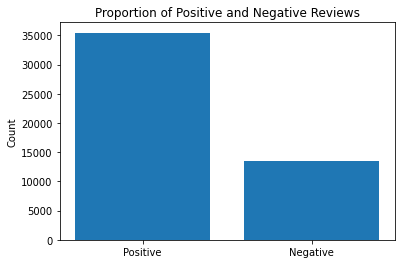

In [11]:
plt.bar(['Positive', 'Negative'], [n_positive, n_negative])
plt.title('Proportion of Positive and Negative Reviews')
plt.ylabel('Count')
plt.show()

In [12]:
train_labels = []
for rating in train['rating']:
       if rating >= 7:
              train_labels.append(1)
       elif rating <= 4:
              train_labels.append(-1)
       else:
              train_labels.append(0)

In [13]:
test_labels = []
for rating in test['rating']:
       if rating >= 7 :
         test_labels.append(1)
       elif rating <= 4:
         test_labels.append(-1)
       else:
         test_labels.append(0)

In [14]:
train_x = []
test_x = []
train_x = train['review']
test_x = test['review']

In [15]:
#initializing the count vectorizer
cv = CountVectorizer(binary=True)
cv.fit(train['review'])
train_x = cv.transform(train_x)
test_x = cv.transform(test_x)

In [16]:
# XGBoost
xgb_train_labels = []
for rating in train['rating']:
       if rating >= 7:
              xgb_train_labels.append(1)
       elif rating <= 4:
              xgb_train_labels.append(0)
       else:
              xgb_train_labels.append(None)

In [17]:
xgb_test_labels = []
for rating in test['rating']:
       if rating >= 7:
              xgb_test_labels.append(1)
       elif rating <= 4:
              xgb_test_labels.append(0)
       else:
              xgb_test_labels.append(None)

In [18]:
xgb_train = xgb.DMatrix(train_x, xgb_train_labels)
xgb_test = xgb.DMatrix(test_x, xgb_test_labels)
param = {'eta': 0.75,
         'max_depth': 10
        }

In [19]:
xgb_model = xgb.train(param, xgb_train, num_boost_round=30)
y_pred_xgb = xgb_model.predict(xgb_test)
y_pred_xgb = np.where(np.array(y_pred_xgb) > 0.5,1,-1)

In [20]:
# xgb Evaluation
accuracy = accuracy_score(test_labels, y_pred_xgb) 
print("Test accuracy :",accuracy)
score = f1_score(test_labels, y_pred_xgb) 
print("F1 score :", score)
confusion_matrix(test_labels,y_pred_xgb)

Test accuracy : 0.813101857207995
F1 score : 0.8773869212120671


array([[21219, 18856],
       [ 8607, 98259]])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'No. of times feature is used to split the data across all trees')

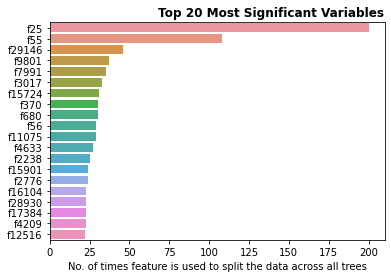

In [21]:
# Exploratory Methods for XGBoost
## looking at feature importance
xgb_scores = xgb_model.get_score(importance_type = 'weight')
xgb_scores = list(xgb_scores.items())
xgb_scores.sort(key = lambda x: x[1], reverse = True)
x = [i[0] for i in xgb_scores[:20]]
y = [i[1] for i in xgb_scores[:20]]
# plot
plot = sns.barplot(y, x)
plot.set_title('Top 20 Most Significant Variables', x = 0.66, weight = 'bold')
plot.set_xlabel('No. of times feature is used to split the data across all trees')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'How effective a feature is when used to split the data across all trees')

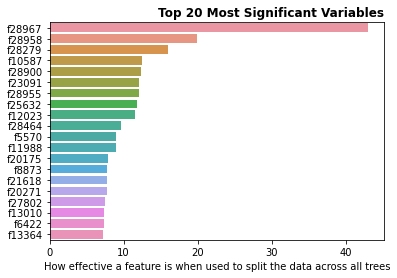

In [22]:
xgb_scores = xgb_model.get_score(importance_type = 'gain')
xgb_scores = list(xgb_scores.items())
xgb_scores.sort(key = lambda x: x[1], reverse = True)
x = [i[0] for i in xgb_scores[:20]]
y = [i[1] for i in xgb_scores[:20]]
# plot
plot = sns.barplot(y, x)
plot.set_title('Top 20 Most Significant Variables', x = 0.66, weight = 'bold')
plot.set_xlabel('How effective a feature is when used to split the data across all trees')